Creation du pokedex pour le retrieval a partir de https://pokeapi.co/

In [10]:
import os
import numpy as np
import time
from tqdm import tqdm
import requests
import json


Nombre de pokemon dispo sur l'api

In [21]:
response = requests.get("https://pokeapi.co/api/v2/pokemon-species?limit=1")
print(response.json()["count"])

1025


In [22]:
NOMBRE_TOTAL_POKEMON = 1025
POKEAPI_BASE_URL = "https://pokeapi.co/api/v2/pokemon/"

POKEDEX_DIRECTORY = "../data/pokedex"


Obtenir les différentes caractéristiques depuis le fichier JSON

In [23]:
def get_url_pokemon(url):
    return requests.get(url).json()

A partir de ceci, on créé les weaknesses, Résistances et immunités.

![Weaknesses pokemon.png](<attachment:Weaknesses pokemon.png>)

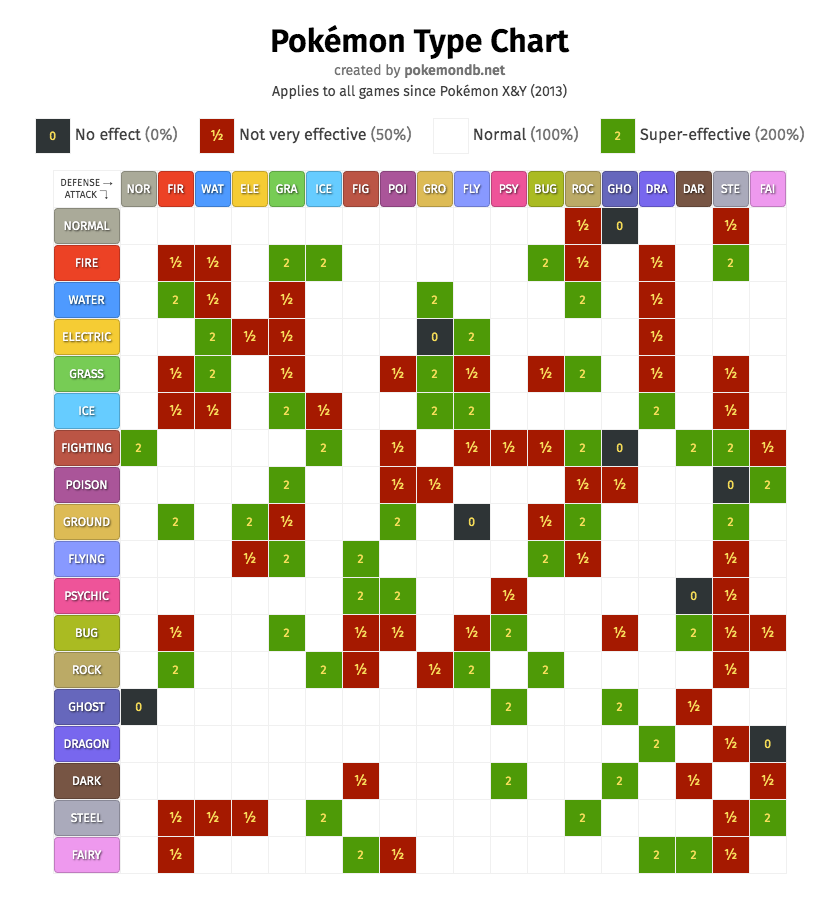

In [24]:
TYPE_WEAKNESSES = {
    "normal": ["fighting"],
    "fire": ["water", "ground", "rock"],
    "water": ["electric", "grass"],
    "electric": ["ground"],
    "grass": ["fire", "ice", "poison", "flying", "bug"],
    "ice": ["fire", "fighting", "rock", "steel"],
    "fighting": ["flying", "psychic", "fairy"],
    "poison": ["ground", "psychic"],
    "ground": ["water", "grass", "ice"],
    "flying": ["electric", "ice", "rock"],
    "psychic": ["bug", "ghost", "dark"],
    "bug": ["fire", "flying", "rock"],
    "rock": ["water", "grass", "fighting", "ground", "steel"],
    "ghost": ["ghost", "dark"],
    "dragon": ["ice", "dragon", "fairy"],
    "dark": ["fighting", "bug", "fairy"],
    "steel": ["fire", "fighting", "ground"],
    "fairy": ["poison", "steel"]
}


TYPE_RESISTANCES = {
    "normal": [],
    "fire": ["fire", "grass", "ice", "bug", "steel", "fairy"],
    "water": ["fire", "water", "ice", "steel"],
    "electric": ["electric", "flying", "steel"],
    "grass": ["water", "electric", "grass", "ground"],
    "ice": ["ice"],
    "fighting": ["bug", "rock", "dark"],
    "poison": ["grass", "fighting", "poison", "bug", "fairy"],
    "ground": ["poison", "rock"],
    "flying": ["grass", "fighting", "bug"],
    "psychic": ["fighting", "psychic"],
    "bug": ["grass", "fighting", "ground"],
    "rock": ["normal", "fire", "poison", "flying"],
    "ghost": ["poison", "bug"],
    "dragon": ["fire", "water", "electric", "grass"],
    "dark": ["ghost", "dark"],
    "steel": [
        "normal", "grass", "ice", "flying", "psychic",
        "bug", "rock", "dragon", "steel", "fairy"
    ],
    "fairy": ["fighting", "bug", "dark"]
}


TYPE_IMMUNITIES = {
    "normal": ["ghost"],
    "fire": [],
    "water": [],
    "electric": ["ground"],
    "grass": [],
    "ice": [],
    "fighting": ["ghost"],
    "poison": [],
    "ground": ["flying"],
    "flying": ["ground"],
    "psychic": ["dark"],
    "bug": [],
    "rock": [],
    "ghost": ["normal"],
    "dragon": ["fairy"],
    "dark": [],
    "steel": [],
    "fairy": ["dragon"]
}



Obtenir les informations sur les pokemons

In [25]:
def description_en_anglais(spieces_data):
    for entry in spieces_data['flavor_text_entries']:
        if entry['language']['name'] == 'en':
            return entry['flavor_text'].replace('\n', ' ').replace('\f', ' ')
    return "No description available in English."

Obtenir les faiblesses, les résistances et les immunités d'un Pokémon en fonction de ses types

In [26]:
def use_weaknesses(types):
    weaknesses = set()
    for t in types:
        weaknesses.update(TYPE_WEAKNESSES.get(t, []))
    return list(weaknesses)

def use_resistances(types):
    resistances = set()
    for t in types:
        resistances.update(TYPE_RESISTANCES.get(t, []))
    return list(resistances)

def use_immunities(types):
    immunities = set()
    for t in types:
        immunities.update(TYPE_IMMUNITIES.get(t, []))
    return list(immunities)

In [27]:
def get_evolution_chain(evolution_chain_url):
    evolution_chain_data = get_url_pokemon(evolution_chain_url)

    def build_tree(chain):
        name = chain["species"]["name"].capitalize()
        return {
            name: {
                child["species"]["name"].capitalize(): build_tree(child)[child["species"]["name"].capitalize()]
                for child in chain.get("evolves_to", [])
            }
        }

    return build_tree(evolution_chain_data["chain"])


In [28]:
def generer_pokedex():
    if not os.path.exists(POKEDEX_DIRECTORY):
        os.makedirs(POKEDEX_DIRECTORY)

    for pokemon_id in tqdm(range(1, NOMBRE_TOTAL_POKEMON + 1)):
        try:
            pokemon_url = f"{POKEAPI_BASE_URL}{pokemon_id}/"
            pokemon_data = get_url_pokemon(pokemon_url)

            name = pokemon_data['name'].capitalize()
            types = [t['type']['name'] for t in pokemon_data['types']]
            height = pokemon_data['height']
            weight = pokemon_data['weight']


            stats = {stat['stat']['name']: stat['base_stat'] for stat in pokemon_data['stats']}

            species_data = get_url_pokemon(pokemon_data['species']['url'])
            description = description_en_anglais(species_data)

            evolution_chain_url = species_data['evolution_chain']['url']
            evolution_chain = get_evolution_chain(evolution_chain_url)

            weaknesses = use_weaknesses(types)
            resistances = use_resistances(types)
            immunities = use_immunities(types)

            pokedex_entry = {
                "Name": name,
                "Types": types,
                "Height": height,
                "Weight": weight,
                "Stats": stats,
                "Description": description,
                "Evolution Chain": evolution_chain,
                "Weaknesses": weaknesses,
                "Resistances": resistances,
                "Immunities": immunities
            }

            filename = os.path.join(POKEDEX_DIRECTORY, f"{pokemon_id}_{name}.json")

            with open(
                filename, 'w', encoding='utf-8'
            ) as f:
                json.dump(pokedex_entry, f, ensure_ascii=False, indent=4)

        except Exception as e:
            print(f"Error processing Pokémon ID {pokemon_id}: {e}")

        time.sleep(0.3)

In [29]:
generer_pokedex()

100%|██████████| 1025/1025 [08:27<00:00,  2.02it/s]
